In [2]:
import warnings;
warnings.filterwarnings('ignore');

In [3]:
import pandas as pd
from my_utils import loader
import os
import pymc3 as pm
import arviz as az
import numpy as np

In [4]:
quest_before = pd.read_csv("datasets/EyeT/Questionnaire_datasetIA.csv")
quest_before.index.name = "Participant"
quest_before.head()

,Participant nr,NR,Created,Modified,Consent,Q1,Q2,Q3,Q4,Q5,...,Q34,Q35,Q36,Q37,Q38,Q39,Q40,Total Score extended,Total Score original,Elapsed time
Participant,,,,,,,,,,,,,,,,,,,,,
1,9199452,07.09.2020 15:13,07.09.2020 15:13,Yes,Proceed,3,3,4,4,3,...,1,4,4,4,1,3,4,134,108,5 minutes 5 seconds
2,9584002,30.09.2020 11:23,30.09.2020 11:23,Yes,Proceed,3,3,4,4,4,...,2,4,3,3,4,2,2,133,105,5 minutes 55 seconds
3,9112363,02.09.2020 09:17,02.09.2020 09:17,Yes,Proceed,2,2,3,4,3,...,3,3,3,3,3,3,3,116,81,6 minutes 49 seconds
4,9727754,06.10.2020 13:20,06.10.2020 13:20,Yes,Proceed,2,3,4,3,2,...,2,3,4,4,2,4,2,114,96,8 minutes 39 seconds
5,9730232,06.10.2020 14:53,06.10.2020 14:53,Yes,Proceed,3,3,4,4,3,...,1,4,2,1,4,4,4,138,106,7 minutes 27 seconds


In [5]:
REGRESSOR_FIX = [
    "B_drift_00_mean",
    "B_drift_11_mean", 
    "B_cross_mean",
    "B_drift_00_sd", 
    "B_drift_11_sd",
    "B_cross_sd", 
    "Sigma_00_mean",
    "Sigma_11_mean",
    "Sigma_cross_mean",
    "Sigma_00_sd",
    "Sigma_11_sd",
    "Sigma_cross_sd",
    "fdur",
    "left_pupil",
    "right_pupil"
]

In [6]:
REGRESSOR_SAC = [
    "B_drift_00_mean",
    "B_drift_11_mean",
    "B_cross_mean",
    "B_drift_00_sd",
    "B_drift_11_sd",
    "B_cross_sd",
    "Sigma_00_mean",
    "Sigma_11_mean",
    "Sigma_cross_mean",
    "Sigma_00_sd",
    "Sigma_11_sd",
    "Sigma_cross_sd",
    "angle",
    "amplitude",
    "duration"
]

## __Free viewing__

<AxesSubplot: >

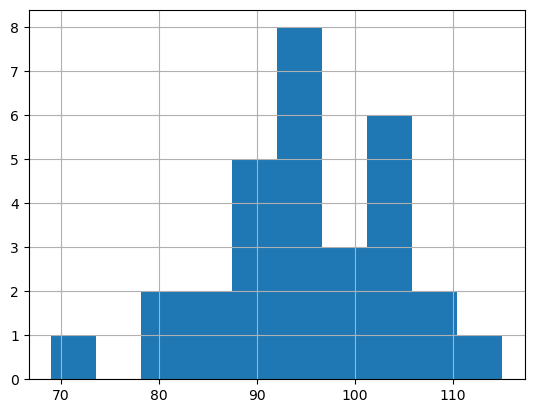

In [7]:
free_viewing_empathy = quest_before[quest_before.index%2 == 0]["Total Score original"]
free_viewing_empathy.hist()

In [ ]:
task_oriented_empathy = quest_before[quest_before.index%2 == 1]["Total Score original"]
task_oriented_empathy.hist()

### __Fixations__

In [21]:
def get_fix_free_features(sub_nr, dset = "train"):
    fix_features, _, _, _ = loader.load_event_features(f"new_long_features/{dset}/event_features_{sub_nr}.npy")
    features_db = pd.DataFrame(fix_features)
    features_db["empathy_level"] = free_viewing_empathy[sub_nr]
    return features_db

free_fix_features = pd.DataFrame()
for filename in os.listdir("new_long_features/train"):
    sub_nr = int(filename.split("_")[2].split(".")[0])
    if sub_nr%2 == 0:
        free_fix_features = free_fix_features.append(get_fix_free_features(sub_nr))
free_fix_features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,empathy_level
0,0.299506,-0.048787,0.453908,0.270468,0.142983,0.373348,6731.224197,-263.077070,10438.336059,3740.270892,203.647744,5466.287529,0.083333,3.320000,3.380000,69
1,0.113325,-0.035577,0.476557,0.098105,0.084157,0.402130,1199.721241,125.312662,10858.274511,804.773953,103.128544,6369.398003,0.058333,3.015000,3.135000,69
2,0.163824,-0.031567,0.362428,0.141207,0.098013,0.305025,3177.454823,-240.416008,17655.261241,1623.136178,133.486905,8155.598527,0.116667,2.870000,3.070000,69
3,0.138441,-0.028495,0.319763,0.116952,0.092460,0.265334,3125.889528,242.570611,5859.651458,1462.611171,129.758732,2687.096698,0.141667,3.080000,3.160000,69
4,0.228698,-0.025236,0.479344,0.209081,0.110595,0.389917,9437.422270,440.746254,16932.425441,5100.976380,229.515481,8781.764714,0.066667,2.930000,3.020000,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,0.043477,-0.030892,0.514348,0.037527,0.070984,0.370015,1495.385409,-112.984808,1745.472601,618.935954,99.822053,693.774439,0.216667,3.912500,3.832500,102
408,0.067245,-0.030283,0.190277,0.054740,0.059136,0.160530,5465.939060,-248.053977,3887.284342,1893.472473,141.235600,1342.957048,0.350000,3.704615,3.602308,102
409,0.052146,-0.031121,0.104076,0.032700,0.041622,0.086567,2351.318694,-178.931379,2477.196984,700.540413,88.788168,662.223001,0.633333,3.732609,3.620000,102
410,0.055587,-0.021852,0.103159,0.041644,0.042780,0.079463,2610.322703,-71.768271,1128.347906,824.373849,104.580011,360.215737,0.475000,3.811579,3.616842,102


In [89]:
with pm.Model() as free_fix_empathy:
    a = pm.Normal("intercept", mu= 0, sigma=20)
    b = pm.Normal("beta", mu=0, sigma=20, shape=len(free_fix_features.columns[:-1]))

    alpha = pm.Exponential("alpha", 0.8)
    # alpha = pm.Normal("alpha", mu=9, sigma = 1)

    data = pm.Data("free_fix_feat", free_fix_features)

    λ = pm.math.exp(a + sum([b[i]*data.eval()[:,i] for i in free_fix_features.columns[:-1]]))

    y = pm.NegativeBinomial("y", mu=λ, alpha=alpha, observed=data.eval()[:,-1])

    free_fix_empathy_trace = pm.sample(init = "adapt_diag", tune=2000)


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 212 seconds.


In [91]:
pois_loo = az.loo(free_fix_empathy_trace, free_fix_empathy)
pois_loo

Computed from 4000 by 1636 log-likelihood matrix

         Estimate       SE
elpd_loo -6090.91    17.65
p_loo       10.02        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1636  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [79]:
az.summary(free_fix_empathy_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,3.85,0.06,3.74,3.97,0.00,0.00,4406.12,3114.22,1.0
beta[0],-0.00,0.16,-0.31,0.29,0.00,0.00,3203.82,2949.74,1.0
beta[1],-0.01,0.02,-0.05,0.04,0.00,0.00,4430.88,3034.87,1.0
beta[2],-0.00,0.01,-0.02,0.01,0.00,0.00,3032.59,2732.21,1.0
beta[3],-0.04,0.23,-0.46,0.38,0.00,0.00,3181.38,2820.68,1.0
beta[4],-0.03,0.08,-0.17,0.13,0.00,0.00,4390.40,3178.16,1.0
beta[5],0.00,0.01,-0.02,0.02,0.00,0.00,3077.86,2598.80,1.0
beta[6],0.00,0.00,-0.00,0.00,0.00,0.00,2284.39,2475.17,1.0
beta[7],0.00,0.00,-0.00,0.00,0.00,0.00,5619.05,2895.04,1.0
beta[8],0.00,0.00,-0.00,0.00,0.00,0.00,2274.09,2583.57,1.0


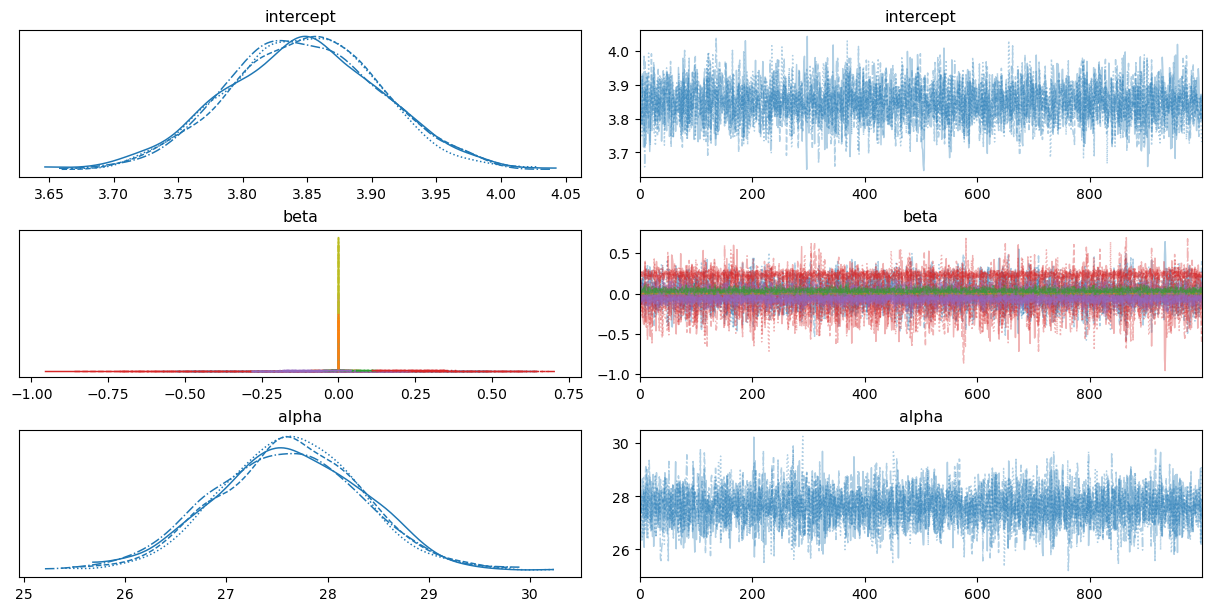

In [80]:
trace = az.plot_trace(free_fix_empathy_trace)

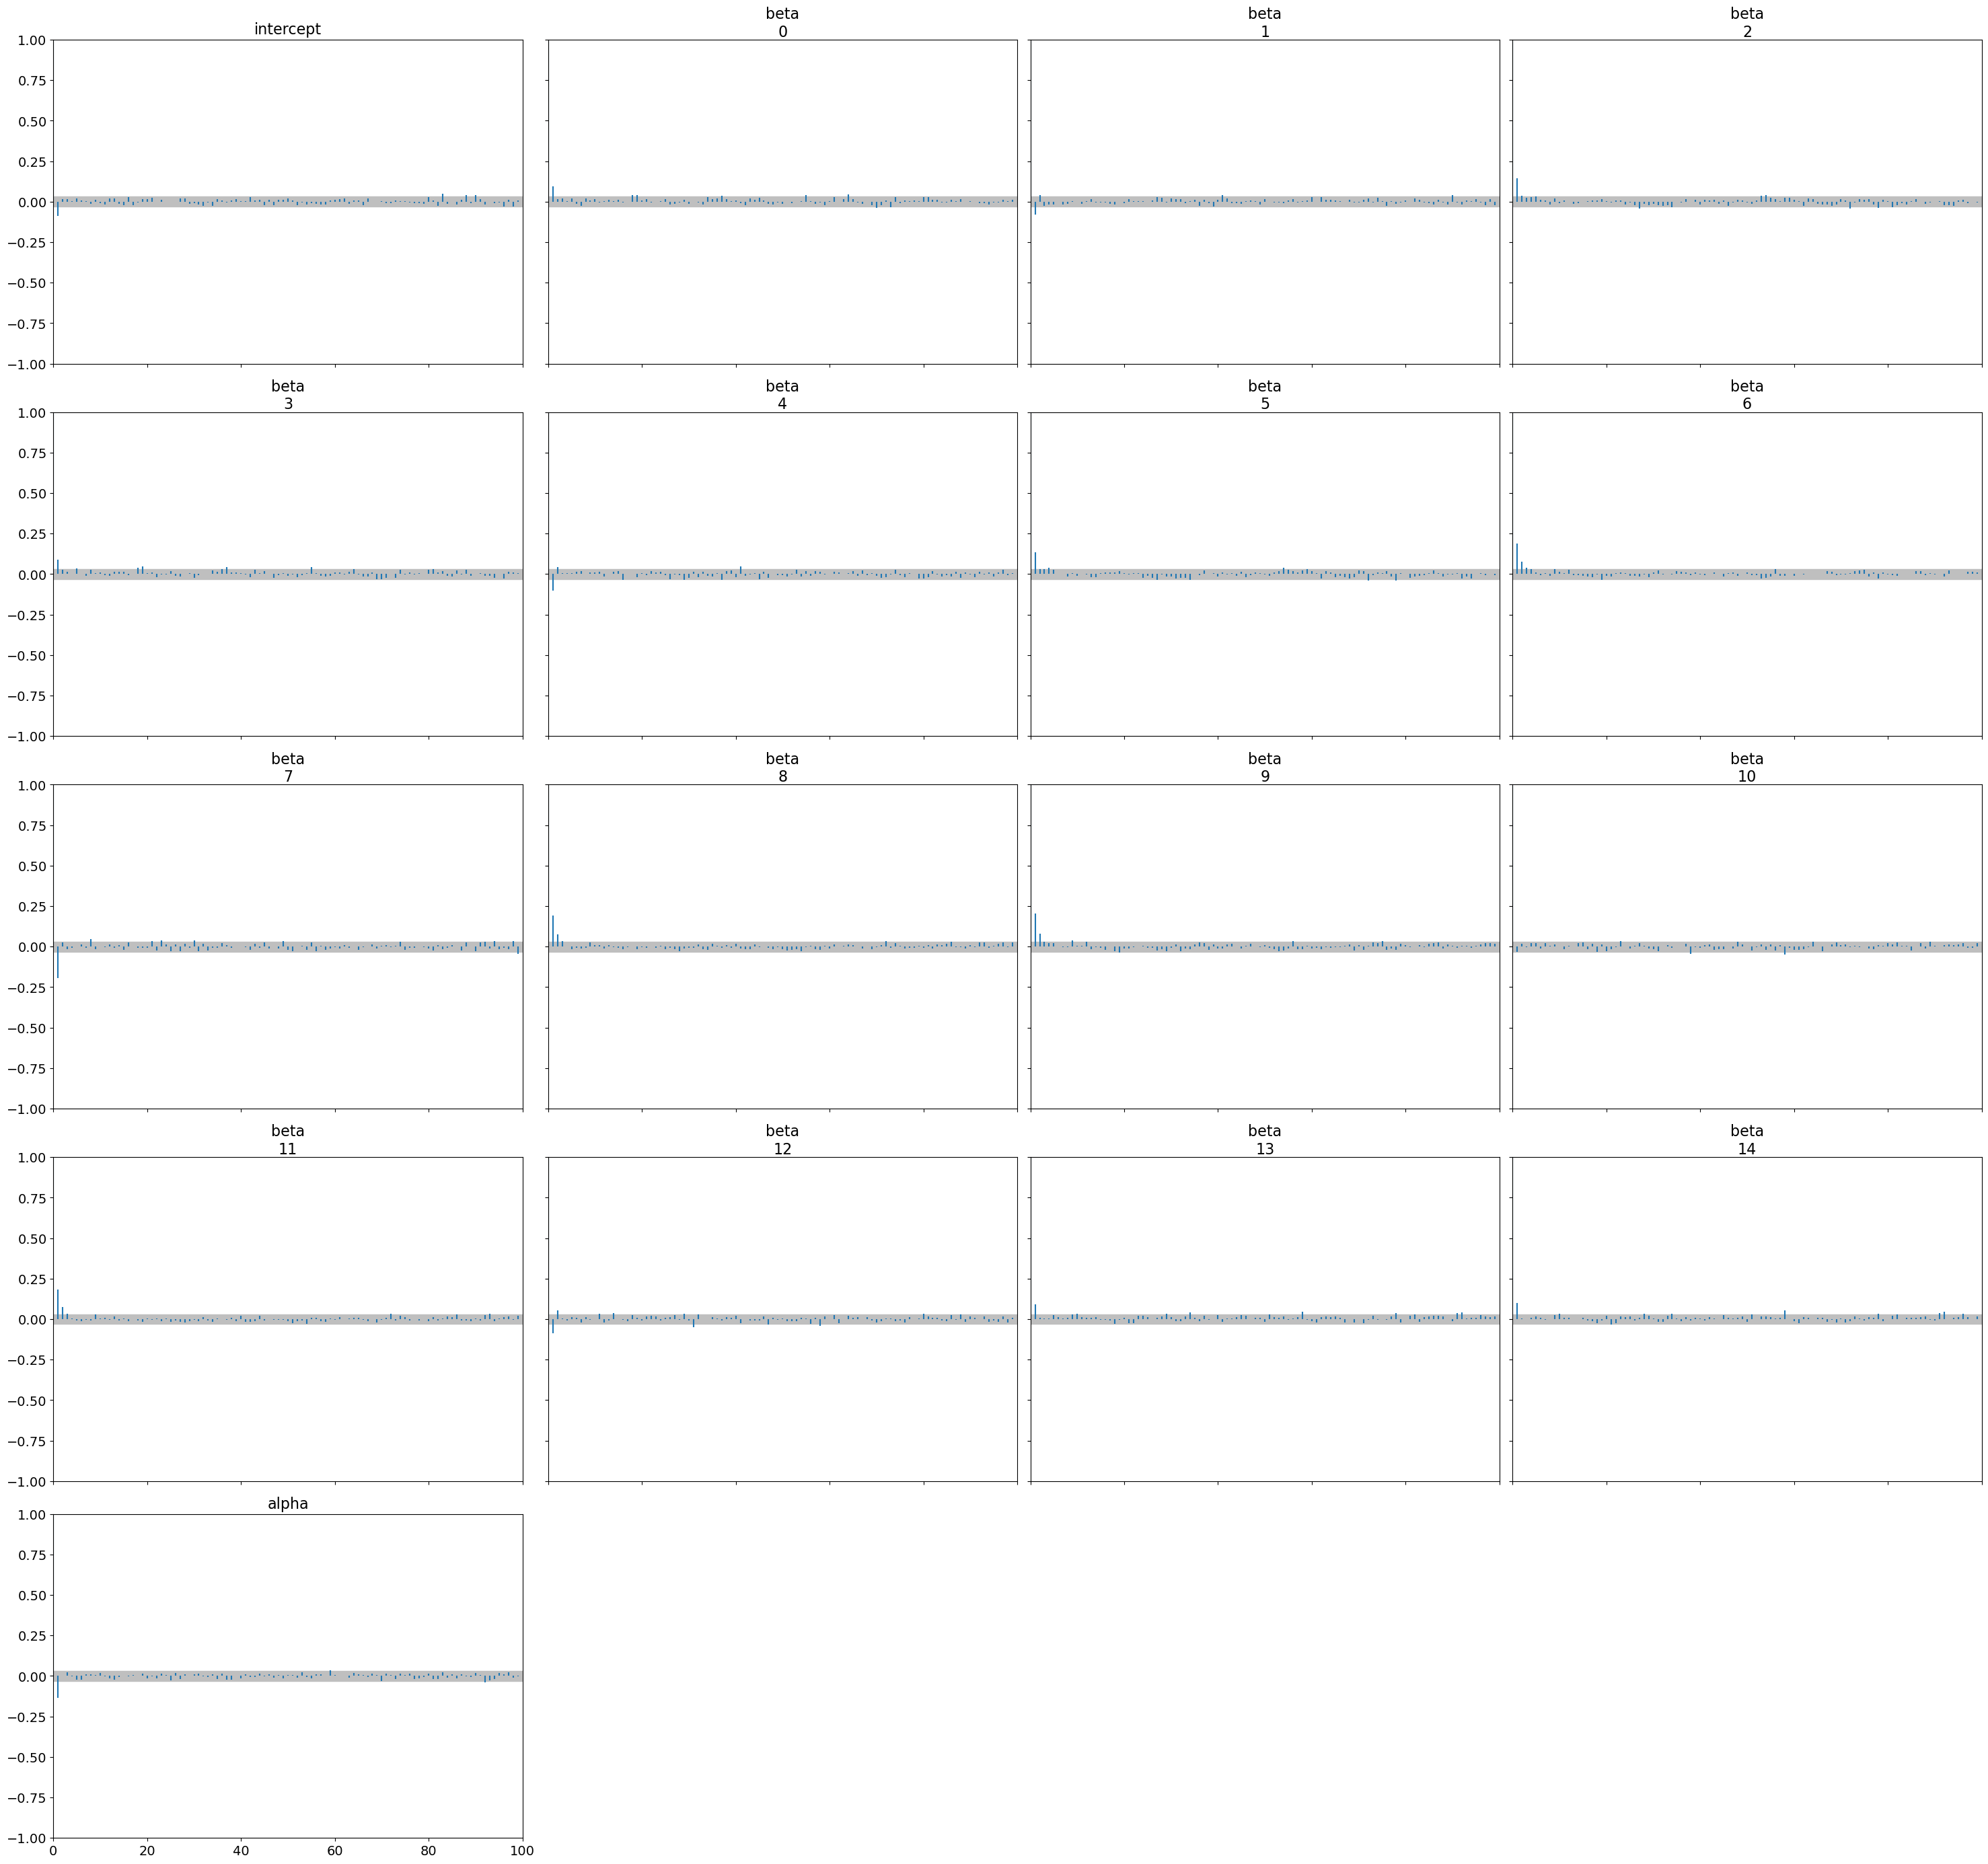

In [32]:
az.plot_autocorr(free_fix_empathy_trace, combined=True);

__Posterior predictive check__

In [92]:
with free_fix_empathy:
    fix_free_ppc = pm.sample_posterior_predictive(free_fix_empathy_trace)

In [93]:
fix_free_ppc_data = az.from_pymc3(model=free_fix_empathy, posterior_predictive=fix_free_ppc) 
fix_free_pred_train = fix_free_ppc_data.posterior_predictive['y'].to_numpy().mean(axis=(0,1))

In [94]:
from sklearn.metrics import mean_squared_error
mean_squared_error(free_fix_features["empathy_level"].values, fix_free_pred_train, squared= False)

9.102975495137139

<AxesSubplot: xlabel='y'>

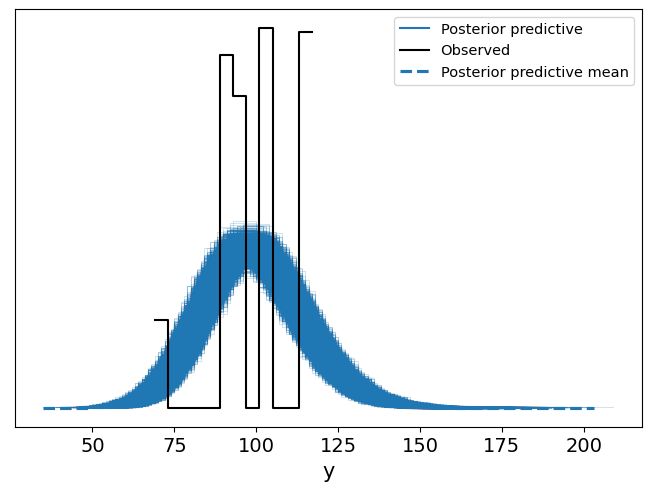

In [95]:
az.plot_ppc(fix_free_ppc_data)

__Feature selection__

In [27]:
from sklearn import feature_selection

statistics, p_values = feature_selection.f_regression(np.array(free_fix_features.loc[:, free_fix_features.columns != "empathy_level"]), fix_free_pred_train)

In [28]:
pd.Series(statistics).rename(lambda i : REGRESSOR_FIX[i]).sort_values(ascending=False)

left_pupil          8018.365430
right_pupil         2373.850890
Sigma_00_mean        170.798146
Sigma_11_sd          145.599078
Sigma_00_sd          100.584678
B_cross_mean          92.773182
B_cross_sd            90.110739
B_drift_11_sd          6.648403
B_drift_11_mean        4.465951
Sigma_11_mean          4.098742
B_drift_00_sd          1.881449
fdur                   1.594764
Sigma_cross_sd         0.573851
B_drift_00_mean        0.476161
Sigma_cross_mean       0.047831
dtype: float64

In [51]:
pred_differences = free_fix_features["empathy_level"].values - fix_free_pred_train
statistics, p_values = feature_selection.f_regression(np.array(free_fix_features.loc[:, free_fix_features.columns != "empathy_level"])[np.where(pred_differences < 5)], fix_free_pred_train[np.where(pred_differences < 5)])
pd.Series(statistics).rename(lambda i : REGRESSOR_FIX[i]).sort_values(ascending=False)

left_pupil          5495.971110
right_pupil         1685.227877
Sigma_00_mean         97.923039
B_cross_mean          62.902886
B_cross_sd            61.536868
Sigma_11_sd           51.945715
Sigma_00_sd           49.413936
Sigma_cross_sd        21.982800
B_drift_11_sd         17.045696
Sigma_cross_mean      13.868414
fdur                  13.507320
B_drift_00_mean        3.373713
B_drift_00_sd          1.759070
Sigma_11_mean          0.840731
B_drift_11_mean        0.036070
dtype: float64

In [53]:
pred_differences = free_fix_features["empathy_level"].values - fix_free_pred_train
statistics, p_values = feature_selection.f_regression(np.array(free_fix_features.loc[:, free_fix_features.columns != "empathy_level"])[np.where(pred_differences > 5)], fix_free_pred_train[np.where(pred_differences > 5)])
pd.Series(statistics).rename(lambda i : REGRESSOR_FIX[i]).sort_values(ascending=False)

left_pupil          2672.727011
right_pupil          723.840558
Sigma_11_sd          168.598306
Sigma_00_mean         85.434141
Sigma_00_sd           66.524741
Sigma_cross_mean      63.089204
Sigma_cross_sd        58.172968
B_drift_00_sd         38.366907
B_drift_00_mean       35.686414
B_cross_mean          34.986218
B_drift_11_mean       33.662892
B_cross_sd            32.960567
fdur                  19.660938
Sigma_11_mean          6.774673
B_drift_11_sd          6.591162
dtype: float64

### __Saccades__

In [97]:
def get_sac_free_features(sub_nr, dset = "train"):
    _, sac_features, _, _ = loader.load_event_features(f"new_long_features/{dset}/event_features_{sub_nr}.npy")
    features_db = pd.DataFrame(sac_features)
    features_db["empathy_level"] = free_viewing_empathy[sub_nr]
    return features_db

free_sac_features = pd.DataFrame()
for filename in os.listdir("new_long_features/train"):
    sub_nr = int(filename.split("_")[2].split(".")[0])
    if sub_nr%2 == 0:
        free_sac_features = free_sac_features.append(get_sac_free_features(sub_nr))
free_sac_features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,empathy_level
0,19.924682,-20.401286,30.133434,7.096898,4.791750,7.750815,40651.994184,-909.355698,21834.606682,14086.368757,209.242610,8755.754347,123.978418,551.101624,0.050000,69
1,3.454659,-0.007308,0.627120,0.966711,0.393833,0.491530,40346.052039,823.379110,23968.950036,15954.985961,307.635407,12355.501965,-95.053826,147.573710,0.050000,69
2,14.641698,0.137735,0.188078,5.801901,0.924878,0.157543,22978.140862,-564.275658,22896.124615,8949.829022,174.679429,9352.358097,-83.290163,376.579341,0.050000,69
3,1.544659,-3.847847,10.997907,0.523657,0.724932,1.636998,49608.483049,-179.839127,3652.929669,17774.414729,128.727740,2002.078664,99.553388,620.606961,0.033333,69
4,4.162048,-0.665146,0.637022,0.935143,0.585640,0.507577,18257.356934,37.974306,14376.532979,9516.970369,254.119596,8945.140288,-76.087505,112.294256,0.033333,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,0.116199,-0.609161,7.154601,0.091462,0.352530,3.778192,47346.091056,-431.597828,19845.946941,17935.732975,306.381195,10337.791292,101.265135,250.832614,0.050000,102
256,0.278948,-0.069495,2.160541,0.209384,0.218632,1.792461,33053.496290,724.200020,21786.238659,16980.071431,375.186719,13245.424957,114.443955,12.083046,0.033333,102
257,6.371413,-6.106444,18.388942,1.252810,1.093959,6.080656,33810.233523,-901.777381,33896.431639,11708.089150,218.329880,13133.047953,-79.840944,351.511024,0.075000,102
258,0.114028,-0.034174,0.309801,0.091710,0.091151,0.267578,37716.711405,863.840807,33697.208137,15672.326565,336.297626,15629.039875,61.882130,148.529458,0.050000,102


In [99]:
with pm.Model() as free_sac_empathy:
    a = pm.Normal("intercept", mu= 0, sigma= 20)
    b = pm.Normal("beta", mu=0, sigma=20, shape=len(free_sac_features.columns[:-1]))

    alpha = pm.Exponential("alpha", 2)

    data = pm.Data("free_sacc_feat", free_sac_features)

    λ = pm.math.exp(a + sum([b[i]*data.eval()[:,i] for i in free_sac_features.columns[:-1]]))

    y = pm.NegativeBinomial("y", mu=λ, alpha=alpha, observed=data.eval()[:,-1])

    free_sac_empathy_trace = pm.sample(init = "adapt_diag", tune=2000)


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 126 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


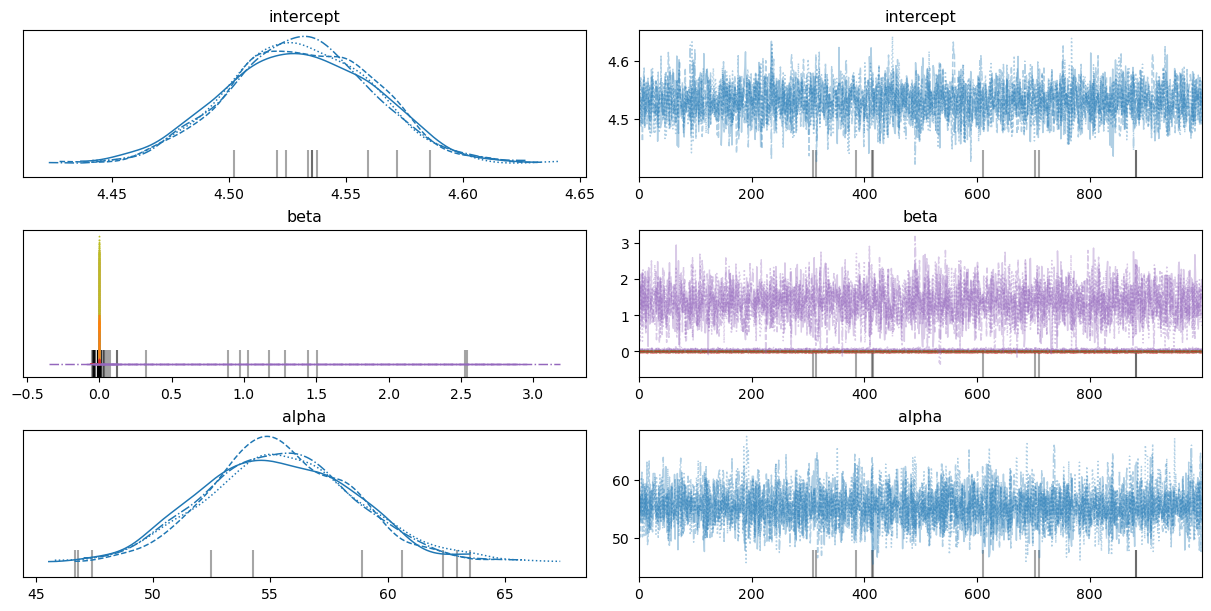

In [100]:
trace = az.plot_trace(free_sac_empathy_trace)

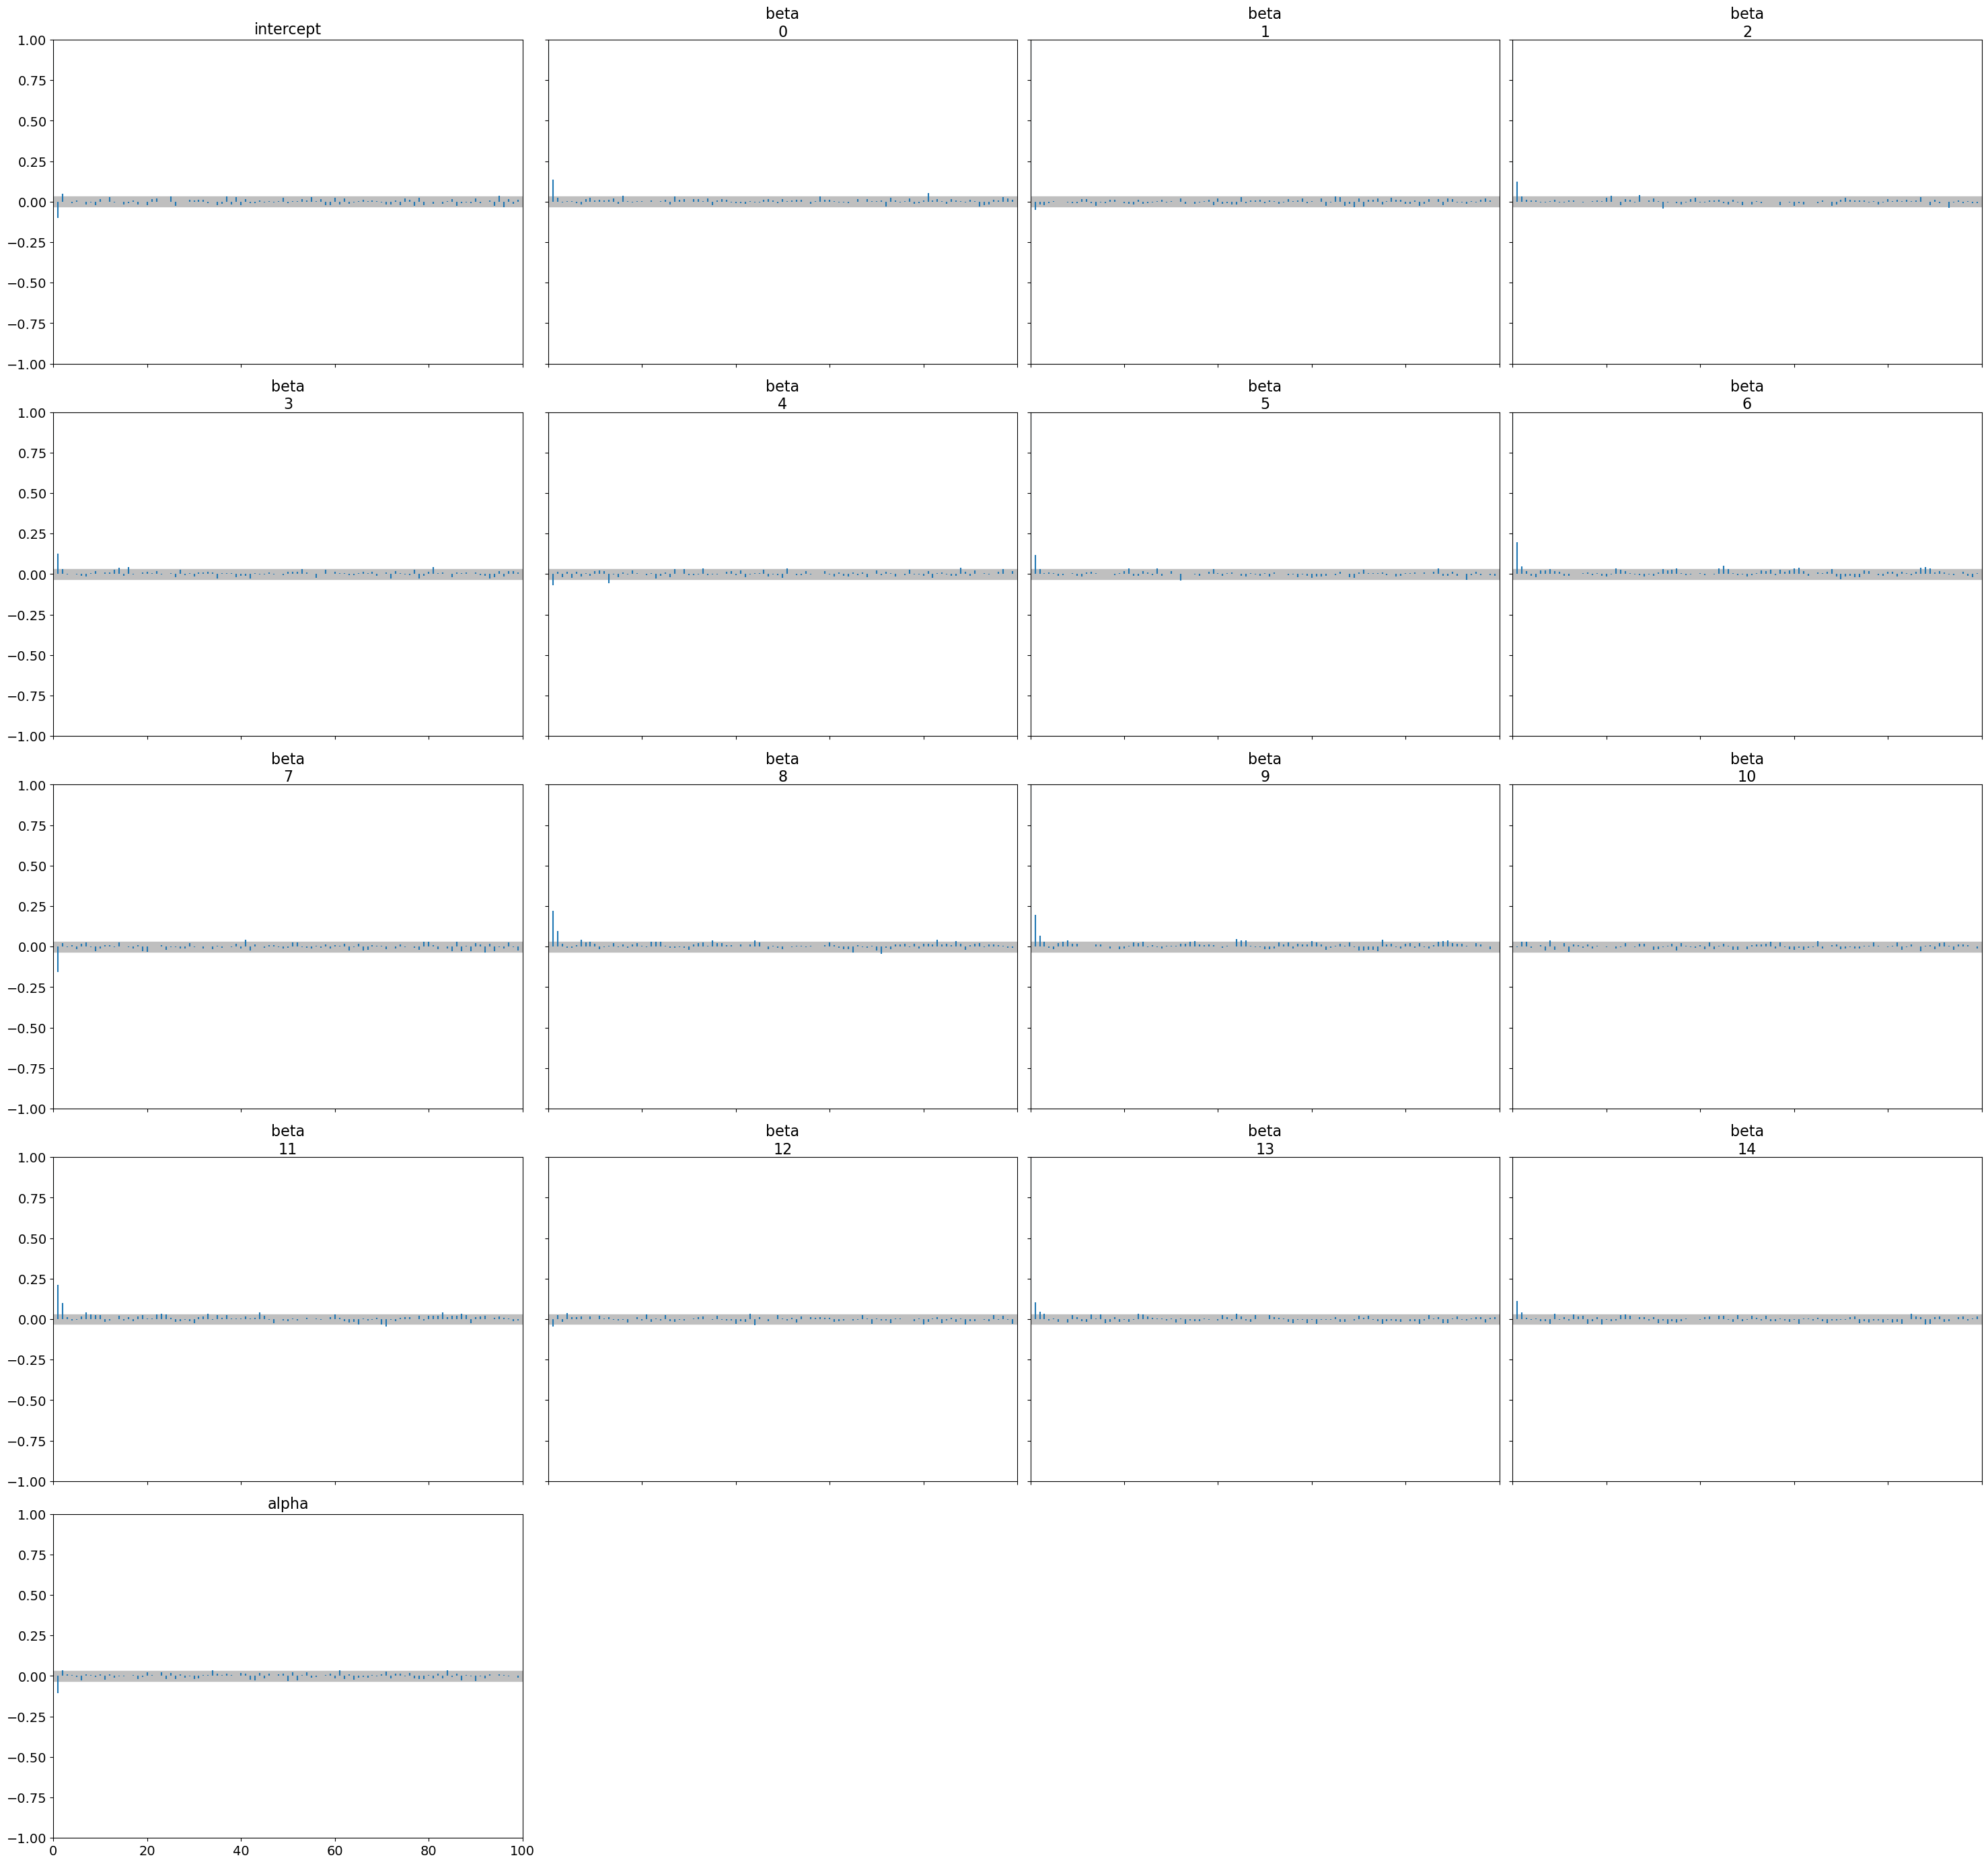

In [102]:
az.plot_autocorr(free_fix_empathy_trace, combined=True);

In [103]:
with free_sac_empathy:
    data.set_value(free_sac_features)
    sac_free_predictions = pm.sample_posterior_predictive(free_sac_empathy_trace)

In [104]:
data_sac_free_predictions = az.from_pymc3(model=free_sac_empathy, posterior_predictive=sac_free_predictions) 
pred_sac_probs = data_sac_free_predictions.posterior_predictive['y'].to_numpy().mean(axis=(0,1))

In [105]:
from sklearn.metrics import mean_squared_error
mean_squared_error(free_sac_features["empathy_level"].values, pred_sac_probs, squared= False)

12.975852666699872

__Feature selection__

In [107]:
from sklearn import feature_selection
statistics, p_values = feature_selection.f_regression(np.array(free_sac_features.loc[:, free_sac_features.columns != "empathy_level"]),pred_sac_probs)

In [108]:
pd.Series(statistics).rename(lambda i : REGRESSOR_SAC[i]).sort_values(ascending=False)

B_drift_00_sd       333.069781
Sigma_cross_mean    272.968813
Sigma_cross_sd      245.756555
amplitude           178.265957
B_drift_00_mean     127.353833
duration             82.124307
Sigma_11_sd          78.483802
B_drift_11_mean      58.934029
Sigma_11_mean        46.885439
Sigma_00_mean        27.400522
Sigma_00_sd          11.220517
B_cross_sd            9.928030
B_cross_mean          6.826222
angle                 4.467498
B_drift_11_sd         0.277782
dtype: float64

__Test__

In [106]:
free_fix_test_features = pd.DataFrame()
for filename in os.listdir("new_long_features/test"):
    sub_nr = int(filename.split("_")[2].split(".")[0])
    if sub_nr%2 == 0:
        free_fix_test_features = free_fix_test_features.append(get_fix_free_features(sub_nr, dset="test"))
free_fix_test_features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,empathy_level
0,0.203973,-0.030062,0.253118,0.181649,0.085761,0.213300,10274.470966,415.509036,3336.580698,6037.146117,236.648508,2090.894892,0.058333,2.880000,2.840000,69
1,0.101654,-0.037299,0.319814,0.084866,0.083290,0.250989,2043.779496,-180.681676,7623.519836,845.245275,104.907107,3054.335274,0.200000,2.886667,2.861667,69
2,0.228204,-0.033831,0.140231,0.207488,0.076841,0.121299,11688.898645,426.008629,1785.570587,5871.147312,225.105912,953.770125,0.091667,2.915000,2.925000,69
3,0.063749,-0.022268,0.141876,0.049965,0.049184,0.117888,2374.620680,-114.201142,5228.715368,740.645194,108.855177,1606.864416,0.483333,2.894444,2.874444,69
4,0.191692,-0.015099,0.193863,0.169867,0.063342,0.153634,3698.279550,275.522889,23359.811904,2070.047120,153.855395,11612.180882,0.075000,2.882500,2.805000,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0.103006,-0.055340,0.456427,0.084608,0.104147,0.383977,2925.471647,-198.531988,4036.553602,1724.369538,143.108796,2255.468560,0.083333,3.873333,3.733333,102
99,0.069593,-0.055876,0.449424,0.053514,0.089295,0.342737,2492.472888,-208.781809,7365.047312,756.030373,99.013611,2297.822576,0.475000,4.116316,3.885789,102
100,0.141121,-0.027930,0.173291,0.117958,0.074283,0.146190,4964.311526,288.100479,2699.444267,1701.202554,134.351298,894.460956,0.358333,3.996000,3.818667,102
101,0.064489,-0.024723,0.119524,0.048814,0.047896,0.093261,2854.080072,230.923562,2470.778841,714.953588,73.296140,594.881817,1.041667,3.993095,3.806429,102


In [130]:
with free_fix_empathy:
    pm.set_data({"free_fix_feat": free_fix_test_features})
    free_fix_test_trace = pm.sample_posterior_predictive(free_fix_empathy_trace, var_names = ["y"], extend_inferencedata=True,)

In [138]:
fix_free_ppc_data_test = az.from_pymc3(model=free_fix_empathy, posterior_predictive=free_fix_test_trace, predictions = True) 
free_fix_test_trace["y"]

TypeError: from_pymc3() got an unexpected keyword argument 'predictions'

In [109]:
free_sac_test_features = pd.DataFrame()
for filename in os.listdir("new_long_features/test"):
    sub_nr = int(filename.split("_")[2].split(".")[0])
    if sub_nr%2 == 0:
        free_sac_test_features = free_sac_test_features.append(get_sac_free_features(sub_nr, dset="test"))
free_sac_test_features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,empathy_level
0,0.460251,-0.387592,0.541223,0.257178,0.213161,0.389579,19588.989421,711.029340,53637.476100,7475.181355,245.560374,19180.943137,19.114802,293.163777,0.033333,69
1,18.300322,1.455671,0.293063,9.882546,1.260709,0.254653,11883.832623,-214.072913,6497.952150,4834.389149,68.695211,2959.572645,-91.926035,565.319379,0.033333,69
2,0.938018,-0.028844,0.275041,0.765789,0.174636,0.210084,28683.416553,741.112290,34995.082510,14517.022741,368.365846,16813.885078,-59.743563,13.892444,0.041667,69
3,4.461779,-4.429512,4.708196,1.344141,0.810214,0.946625,47069.401987,734.756122,9597.108336,16955.254104,223.134343,4835.075580,89.246152,304.026315,0.033333,69
4,1.553461,-3.299022,8.963095,0.746522,0.938690,2.366350,41806.841213,-800.500689,29054.572215,16945.972070,359.316400,14010.952464,116.012376,139.089899,0.041667,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,1.419023,-0.063952,0.791162,0.577303,0.322214,0.641468,28527.296970,-619.711559,19198.828277,14957.821399,357.876768,11232.611794,-91.909152,60.033324,0.041667,102
63,0.225811,-0.076546,1.052349,0.202863,0.195119,0.888327,26102.625058,-600.363300,20535.428729,15162.891719,381.271407,12670.047710,67.380135,26.000000,0.033333,102
64,9.092172,-0.723828,0.431429,2.553470,0.623114,0.333341,18059.377340,-303.629135,16532.590375,7267.120068,152.893802,8096.634634,-82.602427,365.038354,0.041667,102
65,8.339244,-3.637590,2.536705,2.197634,1.288785,1.453300,26065.123111,-705.009818,26024.080368,10281.535914,252.314954,11209.961237,-61.444186,167.358896,0.033333,102


(4000, 1094)


In [158]:
data_sac_free_test_predictions = az.from_pymc3(model=free_sac_empathy, posterior_predictive=sac_free_test_predictions) 
pred_sac_test_probs = data_sac_free_predictions.posterior_predictive['y'].to_numpy().mean(axis=(0,1))

In [188]:
with free_fix_empathy:
    pm.set_data({"fixation_features": free_fix_test_features})
    fix_free_test_predictions = pm.sample_posterior_predictive(free_fix_empathy_trace)